In [1]:
#Solution adapted from DataCamp LSTM Python Stock Market
#https://www.datacamp.com/community/tutorials/lstm-python-stock-market

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot



In [2]:
# Prolog - Auto Generated #
import os, matplotlib.pyplot, uuid, pandas
import pandas_datareader as dr
import datetime
import pandas_datareader.data as web

In [3]:
start=datetime.datetime(2012,1,1)
end=datetime.datetime(2019,4,1)

In [4]:
# tesla = web.DataReader('TSLA', 'google', start,end)
tesla = dr.data.get_data_yahoo('TSLA', start=start, end=end)

In [5]:
 # First calculate the mid prices from the highest and lowest
high_prices = tesla.loc[:,'High'].as_matrix()
low_prices = tesla.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0
train_length = int(len(high_prices) * 0.8)
train_data = mid_prices[:train_length]
test_data = mid_prices[train_length:]

In [6]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [7]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 200
for di in range(0,train_length-smoothing_window_size,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])


# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [25]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [37]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(train_length):
    
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [38]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [2.3258515e-04 7.5460427e-02 7.2550309e-01 5.3664362e-01 6.3378406e-01]

	Output: [0.00082264 0.07593602 0.72247875 0.55594367 0.6421978 ]


Unrolled index 1
	Inputs:  [0.00082264 0.07593602 0.72247875 0.5463261  0.63666975]

	Output: [0.00314035 0.07632875 0.71223295 0.58484167 0.63666975]


Unrolled index 2
	Inputs:  [0.00179681 0.07632875 0.719214   0.55594367 0.639486  ]

	Output: [0.00681017 0.07666009 0.719214   0.57516575 0.6421978 ]


Unrolled index 3
	Inputs:  [0.00314035 0.07666009 0.7157688  0.5655395  0.6421978 ]

	Output: [0.00681017 0.07694999 0.7051657  0.5655395  0.6494989 ]


Unrolled index 4
	Inputs:  [0.00480799 0.07694999 0.71223295 0.57516575 0.6447811 ]

	Output: [0.00681017 0.07777548 0.71223295 0.57516575 0.64721835]


In [41]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = int(train_length/5) # Number of samples in a batch
num_nodes = [100,100,50] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [42]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [43]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [44]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [45]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [46]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [95]:
epochs = 30
valid_summary = 1# Interval you make test predictions

n_predict_once = 50# Number of steps you continously predict for

train_seq_length = train_data.size# Full length of the training data

train_mse_ot = []# Accumulate Train losses
test_mse_ot = []# Accumulate Test loss
predictions_over_time = []# Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2# If the test error hasn 't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data, batch_size, num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(1500, 1773, 50).tolist()

for ep in range(epochs):

  # === === === === === === === === = Training === === === === === === === === === === === === =
    for step in range(train_seq_length //batch_size):
        u_data, u_labels = data_gen.unroll_batches()
        feed_dict = {}
        for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
            feed_dict[train_inputs[ui]] = dat.reshape(-1, 1) 
            feed_dict[train_outputs[ui]] = lbl.reshape(-1, 1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate: 0.000001})
        _, l = session.run([optimizer, loss], feed_dict = feed_dict)

        average_loss += l

    # === === === === === === === === === = Validation === === === === === === === === === ===
    if (ep + 1) % valid_summary == 0:
        average_loss = average_loss / (valid_summary * (train_seq_length //batch_size))

        # The average loss
        if (ep + 1) % valid_summary == 0:
            print('Average loss at step %d: %f' % (ep + 1, average_loss))

        train_mse_ot.append(average_loss)

        average_loss = 0# reset loss

        predictions_seq = []

        mse_test_loss_seq = []

        # === === === === === === === Updating State and Making Predicitons === === === === === === === ===
        for w_i in test_points_seq:
            mse_test_loss = 0.0 
            our_predictions = []

            if (ep + 1) - valid_summary == 0: 
                #Only calculate x_axis values in the first validation epoch
                x_axis = []

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i - num_unrollings + 1, w_i - 1):
            current_price = all_mid_data[tr_i] 
            
            feed_dict[sample_inputs] = np.array(current_price).reshape(1, 1)
            _ = session.run(sample_prediction,feed_dict=feed_dict)
            
        feed_dict = {}
        
        current_price = all_mid_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1, 1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it 's current input
        for pred_i in range(n_predict_once):
            pred = session.run(sample_prediction, feed_dict=feed_dict)

            our_predictions.append(np.asscalar(pred))

            feed_dict[sample_inputs] = np.asarray(pred).reshape(-1, 1)

            if (ep + 1) - valid_summary == 0: 
                #Only calculate x_axis values in the first validation epoch
                x_axis.append(w_i + pred_i)

            mse_test_loss += 0.5 * (pred - all_mid_data[w_i + pred_i]) ** 2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once 
        mse_test_loss_seq.append(mse_test_loss)

        if (ep + 1) - valid_summary == 0:
            x_axis_seq.append(x_axis)

        current_test_mse = np.mean(mse_test_loss_seq)

        # Learning rate decay logic
        if len(test_mse_ot) > 0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else :
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold:
            session.run(inc_gstep) 
            loss_nondecrease_count = 0 
            print('\tDecreasing learning rate by 0.5')

        test_mse_ot.append(current_test_mse) 
        print('\tTest MSE: %.5f' % np.mean(mse_test_loss_seq)) 
        predictions_over_time.append(predictions_seq) 
        print('\tFinished Predictions')

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 3.890574
	Test MSE: 0.05136
	Finished Predictions
Average loss at step 2: 3.207553
	Test MSE: 0.06119
	Finished Predictions
Average loss at step 3: 2.081793
	Test MSE: 0.08200
	Finished Predictions
Average loss at step 4: 1.115015
	Decreasing learning rate by 0.5
	Test MSE: 0.13265
	Finished Predictions
Average loss at step 5: 0.548682
	Test MSE: 0.18488
	Finished Predictions
Average loss at step 6: 0.496158
	Test MSE: 0.23357
	Finished Predictions
Average loss at step 7: 0.494837
	Decreasing learning rate by 0.5
	Test MSE: 0.22688
	Finished Predictions
Average loss at step 8: 0.453477
	Test MSE: 0.20847
	Finished Predictions
Average loss at step 9: 0.432397
	Test MSE: 0.19176
	Finished Predictions
Average loss at step 10: 0.442746
	Decreasing learning rate by 0.5
	Test MSE: 0.18477
	Finished Predictions
Average loss at step 11: 0.425456
	Test MSE: 0.18542
	Finished Predictions
Average loss at step 12: 0.443829
	Test MSE: 0.18774
	Finished Prediction

[1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799]
[1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799]
[1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799]
[1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 

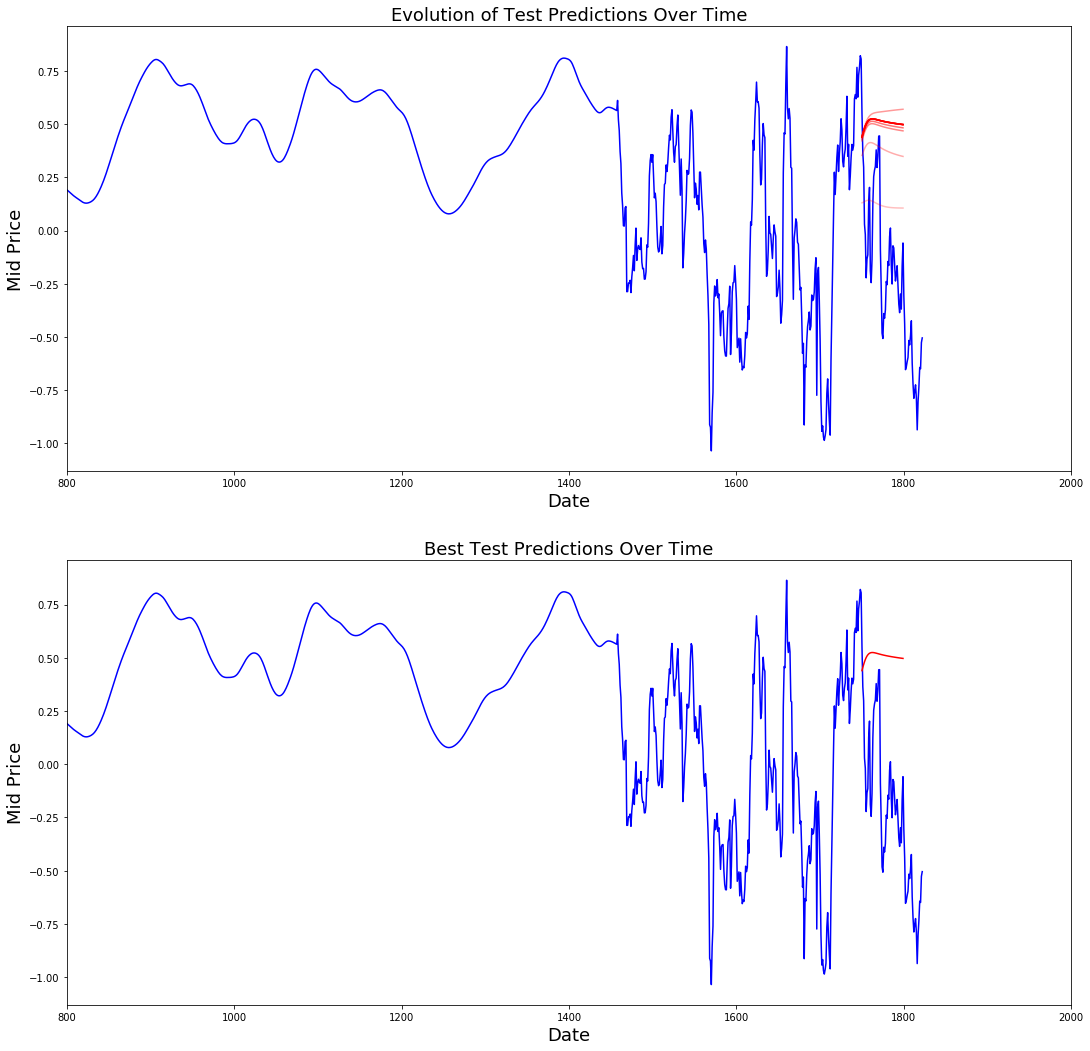

In [107]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(tesla.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        print(xval)
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(800,2000)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(tesla.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(800,2000)
plt.show()